In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#FF0000','#0000FF'])
cmap_light = ListedColormap('#FFBBBB','#BBBBFF')

In [2]:
def linear(x):
    return x

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def leaky_ReLU(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def swish(x):
    return x * sigmoid(x)

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=1, keepdims=True)

# Define the derivative function
def derivative(Z, a, alpha=0.01):
    if a == linear:
        return 1
    elif a == sigmoid:
        return Z * (1 - Z)
    elif a == np.tanh:
        return 1 - Z**2
    elif a == ReLU:
        return (Z > 0).astype(int)
    elif a == leaky_ReLU:
        return np.where(Z > 0, 1, alpha)
    elif a == swish:
        return sigmoid(Z) + Z * sigmoid(Z) * (1 - sigmoid(Z))
    else:
        raise ValueError("Unknown Activation")

In [3]:
def cross_entropy(Y,P_hat):
  return -(1/len(Y))*np.sum(np.sum(Y*np.log(P_hat),axis=1),axis=0)

def indices_to_one_hot(data, nb_classes):
  targets = np.array(data).reshape(-1)
  return np.eye(nb_classes)[targets]

def accuracy(y, y_hat):
  return np.mean(y==y_hat)

In [54]:
def calculate_f1_score(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    f1 = 2 * (precision * recall) / (precision + recall)

    return f1, precision, recall


def calculate_confusion_matrix(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    return np.array([[TN, FP], [FN, TP]])





In [7]:
df = pd.read_csv("/Churn_Modelling.csv")

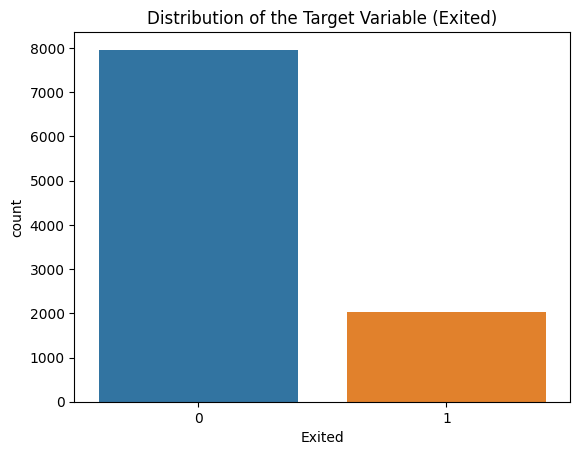

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:

numerical_summary = df.describe()


sns.countplot(data=df, x='Exited')
plt.title('Distribution of the Target Variable (Exited)')
plt.show()

numerical_summary


In [9]:
df_dropped = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df_dropped.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [10]:
geo_mapping = {label: idx for idx, label in enumerate(df['Geography'].unique())}
df['Geography_idx'] = df['Geography'].map(geo_mapping)
gender_mapping = {label: idx for idx, label in enumerate(df['Gender'].unique())}
df['Gender_idx'] = df['Gender'].map(gender_mapping)
geo_one_hot = indices_to_one_hot(df['Geography_idx'], len(geo_mapping))
gender_one_hot = indices_to_one_hot(df['Gender_idx'], len(gender_mapping))
geo_df = pd.DataFrame(geo_one_hot, columns=[f"Geography_{label}" for label in geo_mapping.keys()])
gender_df = pd.DataFrame(gender_one_hot, columns=[f"Gender_{label}" for label in gender_mapping.keys()])
df_dropped = df.drop(['Geography', 'Gender', 'Geography_idx', 'Gender_idx'], axis=1)
df_one_hot = pd.concat([df_dropped, geo_df, gender_df], axis=1)
df_one_hot.head()


,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male
0,1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0,1.0,0.0
1,2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0.0,1.0,0.0,1.0,0.0
2,3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0,1.0,0.0
3,4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0,1.0,0.0
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0.0,1.0,0.0,1.0,0.0


In [11]:
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df_normalized = df_one_hot.copy()
for col in numerical_cols:
    min_val = df_one_hot[col].min()
    max_val = df_one_hot[col].max()
    df_normalized[col] = (df_one_hot[col] - min_val) / (max_val - min_val)
df_normalized.head()


,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male
0,1,15634602,Hargrave,0.538,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,1.0,0.0,0.0,1.0,0.0
1,2,15647311,Hill,0.516,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,0.0,1.0,0.0,1.0,0.0
2,3,15619304,Onio,0.304,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,1.0,0.0,0.0,1.0,0.0
3,4,15701354,Boni,0.698,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,1.0,0.0,0.0,1.0,0.0
4,5,15737888,Mitchell,1.000,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,0.0,1.0,0.0,1.0,0.0


In [12]:
class_counts = df_normalized['Exited'].value_counts()
class_counts


0    7963
1    2037
Name: Exited, dtype: int64

In [13]:
df_majority = df_normalized[df_normalized.Exited == 0]
df_minority = df_normalized[df_normalized.Exited == 1]
df_minority_oversampled = df_minority.sample(n=class_counts[0], replace=True, random_state=42)
df_oversampled = pd.concat([df_majority, df_minority_oversampled])
df_oversampled.Exited.value_counts()


0    7963
1    7963
Name: Exited, dtype: int64

In [14]:
X = df_oversampled.drop(['Exited'], axis=1).values
y = df_oversampled['Exited'].values
X.shape, y.shape


((15926, 16), (15926,))

In [15]:
class MVLogisticRegression():
  def fit(self,X,y, eta=1e-1,epochs=1e3, show_curve=False):
    epochs = int(epochs)
    N, D = X.shape
    K = len(np.unique(y))
    y_values = np.unique(y, return_index=False)
    Y = indices_to_one_hot(y, K).astype(int)

    #initialize weights and biases
    self.W = np.random.randn(D,K)
    self.B = np.random.randn(N,K)
    J = np.zeros(epochs)
    for epoch in range(epochs):
      P_hat = self.__forward__(X)
      J[epoch] = cross_entropy(Y, P_hat)
      #weight update rules
      self.W -= eta*(1/N)*X.T@(P_hat-Y)
      self.B -= eta*(1/N)*np.sum(P_hat-Y,axis=0)

    if show_curve:


      plt.figure()
      plt.plot(J)
      plt.xlabel("epochs")
      plt.ylabel("$\mathcal{J}$")
      plt.title("Training Curve")
      plt.show
  def __forward__(self,X):
    return softmax(X@self.W+self.B)

  def predict(self, X):
    return np.argmax(self.__forward__(X),axis=1)

In [16]:
df_oversampled_clean = df_oversampled.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

X = df_oversampled_clean.drop(['Exited'], axis=1).values
y = df_oversampled_clean['Exited'].values
X = X.astype(float)
X.shape, y.shape


((15926, 13), (15926,))

In [17]:
df_oversampled_clean

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male
1,0.516,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,0.0,1.0,0.0,1.0,0.0
3,0.698,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,1.0,0.0,0.0,1.0,0.0
4,1.000,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,0.0,1.0,0.0,1.0,0.0
6,0.944,0.432432,0.7,0.000000,0.333333,1,1,0.050261,0,1.0,0.0,0.0,0.0,1.0
8,0.302,0.351351,0.4,0.566170,0.333333,0,1,0.374680,0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5701,0.550,0.418919,0.4,0.512179,0.000000,1,0,0.634066,1,0.0,0.0,1.0,1.0,0.0
9337,0.232,0.391892,0.5,0.406881,0.000000,1,1,0.917711,1,0.0,0.0,1.0,1.0,0.0
4345,0.740,0.378378,0.3,0.386781,0.000000,1,1,0.667588,1,0.0,0.0,1.0,0.0,1.0
1085,0.906,0.324324,0.5,0.000000,0.000000,1,0,0.982370,1,1.0,0.0,0.0,0.0,1.0


In [18]:
shuffled_indices = np.random.permutation(len(X))
X_shuffled = X[shuffled_indices]
y_shuffled = y[shuffled_indices]

train_size = int(0.8 * len(X))
X_train = X_shuffled[:train_size]
y_train = y_shuffled[:train_size]
X_test = X_shuffled[train_size:]
y_test = y_shuffled[train_size:]


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12740, 13), (12740,), (3186, 13), (3186,))

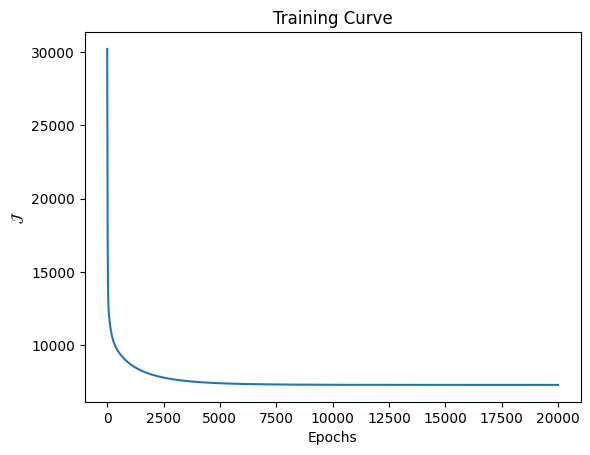

0.6939736346516008

In [27]:
lr = MVLogisticRegression()
lr.fit(X_train, y_train,eta=4e-2,epochs=2e4, show_curve=True)

y_hat_test_mvlr = lr.predict(X_test)


acc = accuracy(y_test, y_hat_test_mvlr)
acc



In [28]:

acc

0.6939736346516008

The F1 score is: 0.6945
The precision score is: 0.6827
The recall score is: 0.7066


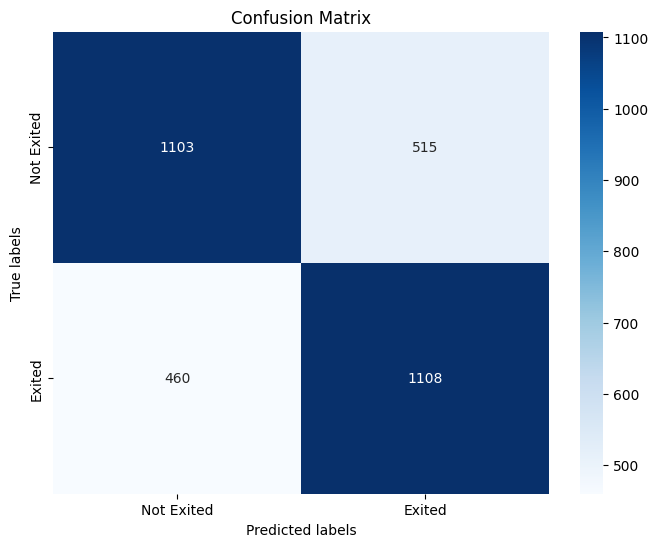

In [55]:
f1_calculated, precision, recall = calculate_f1_score(y_test, y_hat_test_mvlr)
conf_matrix_calculated = calculate_confusion_matrix(y_test, y_hat_test_mvlr)

f1_calculated, conf_matrix_calculated
print(f"The F1 score is: {(f1_calculated):0.4f}")
print(f"The precision score is: {(precision):0.4f}")
print(f"The recall score is: {(recall):0.4f}")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_calculated, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Not Exited', 'Exited'],
            yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Modified MVLogisticRegression class
class MVLogisticRegression():
    def fit(self, X, y, eta=2e-1, epochs=1e3, show_curve=False):
        epochs = int(epochs)
        N, D = X.shape
        K = len(np.unique(y))
        Y = indices_to_one_hot(y, K).astype(int)

        # Initialize weights and biases
        self.W = np.random.randn(D, K)
        self.B = np.random.randn(K)  # Modified to 1D array

        J = np.zeros(epochs)  # to store the cost at each epoch

        for epoch in range(epochs):
            P_hat = self.__forward__(X)
            J[epoch] = cross_entropy(Y, P_hat)

            # Gradient Descent
            self.W -= eta * (1/N) * X.T @ (P_hat - Y)
            self.B -= eta * (1/N) * np.sum(P_hat - Y, axis=0)

        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("Epochs")
            plt.ylabel("$\mathcal{J}$")
            plt.title("Training Curve")
            plt.show()

    def __forward__(self, X):
        return softmax(X @ self.W + self.B)  # Modified to include 1D bias array

    def predict(self, X):
        return np.argmax(self.__forward__(X), axis=1)

# Test the modification by training and predicting using a subset of the dataset
# (Note: This is just to test the modified class; we'll properly shuffle and split the data next)
test_mv_lr = MVLogisticRegression()
test_mv_lr.fit(X[:1000], y[:1000])
y_pred_test = test_mv_lr.predict(X[1000:1100])

# Display the first 10 predictions to confirm that the class works without errors
y_pred_test[:10]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
## Simple Logistic Regression
class LogisticRegression():

  def __init__(self, thresh=0.5):
    self.thresh = thresh
    self.W = None
    self.b = None

  def fit(self, X,y,eta = 1e-3, epochs=1e3, show_curve = False):

    epochs = int(epochs)
    N,D = X.shape

  #SGD START
  #Initialiaze weight set
    self.W = np.random.randn(D)
    self.b = np.random.randn(1)

    J = np.zeros(epochs)

    for epoch in range(epochs):
      p_hat = self.__forward__(X)
      J[epoch] = cross_entropy(y,p_hat)
      #Weight update rule
      self.W -= eta*(1/N)*X.T@(p_hat-y)
      self.b -= eta*(1/N)*np.sum(p_hat-y)

    if show_curve:

      plt.figure()
      plt.plot(J)
      plt.xlabel("epochs")
      plt.ylabel("$\mathcal{J}$")
      plt.title("Training Curve")
      plt.show

  def __forward__(self,X):
    return sigmoid(X@self.W+self.b)

  def predict(self, X):
    return(self.__forward__(X)>=self.thresh).astype(np.int32)

0.6930320150659134

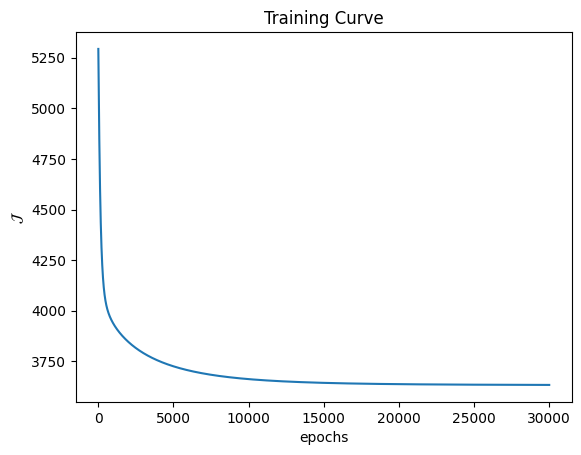

In [31]:
lr = LogisticRegression()
lr.fit(X_train, y_train,eta=4e-2,epochs=3e4, show_curve=True)

y_pred_testlr = lr.predict(X_test)


acc = accuracy(y_test, y_pred_testlr)
acc

The F1 score is: 0.6932
The precision score is: 0.6821
The recall score is: 0.7047


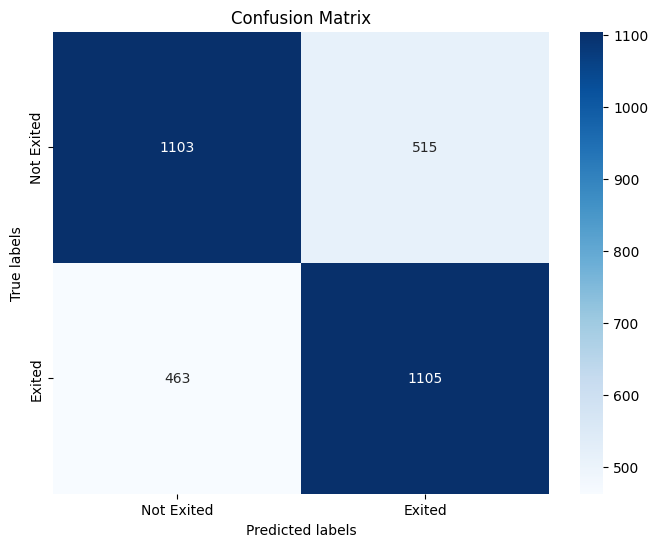

In [56]:
f1_calculated, precision, recall = calculate_f1_score(y_test, y_pred_testlr)
conf_matrix_calculated = calculate_confusion_matrix(y_test, y_pred_testlr)

f1_calculated, conf_matrix_calculated
print(f"The F1 score is: {(f1_calculated):0.4f}")
print(f"The precision score is: {(precision):0.4f}")
print(f"The recall score is: {(recall):0.4f}")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_calculated, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Not Exited', 'Exited'],
            yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
mv_lr = MVLogisticRegression()
lr.fit(X_train, y_train,eta=4e-2,epochs=2e4, show_curve=True)

y_hat_trainmvlr = mv_lr.predict(X_train)


acc = accuracy(y_train, y_hat_trainmvlr)
acc

In [25]:
class Shallow_ANN():

  def fit(self, X,y, neurons = 6, eta=1, epochs = 1e3, show_curve = False):

    epochs = int(epochs)
    N, D = X.shape
    Y = one_hot_encode(y)
    K = Y.shape[1]

    #Initialize Weights
    self.W = {l: np.random.randn(M[0],M[1]) for l, M in enumerate(zip([D,neurons],[neurons,K]),1)}
    self.B = {l: np.random.randn(M) for l,M in enumerate([neurons,K],1)}
#define Activations
    self.a = {1: np.tanh, 2:softmax}

    J =np.zeros(epochs)

    for epoch in range(epochs):
      self.__forward__(X)
      J[epoch] = cross_entropy(Y,self.Z[2])
      #Weight Updates for layer 2
      self.W[2] -= eta*(1/N)*self.Z[1].T@(self.Z[2]-Y)
      self.B[2] -= eta*(1/N)*(self.Z[2]-Y).sum(axis=0)
      #Weight Updates for Layer 1
      self.W[1] -= eta*(1/N)*X.T@((self.Z[2]-Y)@self.W[2].T*(1-self.Z[1]**2))
      self.B[1] -= eta*(1/N)*((self.Z[2]-Y)@self.W[2].T*(1-self.Z[1]**2)).sum(axis=0)

    if show_curve:

      plt.figure()
      plt.plot(J)
      plt.xlabel("epochs")
      plt.ylabel("$\mathcal{J}$")
      plt.title("Training Curve")
      plt.show()

  def __forward__(self, X):
    self.Z = {0:X}
    for l in sorted(self.W.keys()):
      self.Z[l] = self.a[l](self.Z[l-1]@self.W[l]+self.B[l])

  def predict(self,X):
    self.__forward__(X)
    return self.Z[2].argmax(axis=1)


In [24]:
#Activations
def linear(H):
  return H

def ReLu(H):
  return H*(H>0)

def sigmoid(H):
  return 1/(1+np.exp(-H))

def softmax(H):
  eH = np.exp(H)
  return eH/eH.sum(axis=1, keepdims=True)
#misc
def one_hot_encode(y):
  N = len(y)
  K = len(set(y))
  Y = np.zeros((N,K))
  for i in range(N):
    Y[i,y[i]] = 1
  return Y
def accuracy(y, y_hat):
  return np.mean(y==y_hat)

def cross_entropy(Y,P_hat):
  return -np.sum(Y*np.log(P_hat))

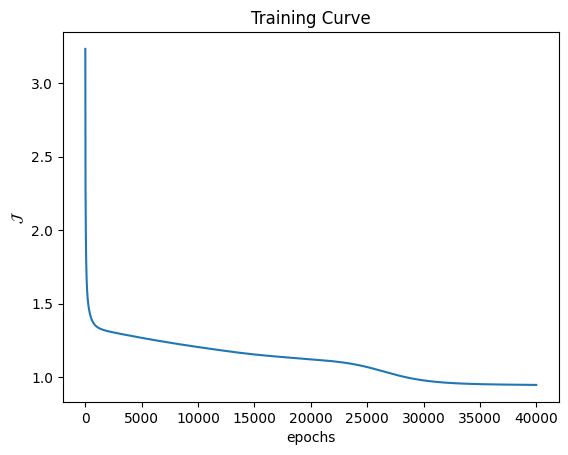

0.7671899529042386

In [48]:
sann = Shallow_ANN()
sann.fit(X_train, y_train,neurons=14,eta=2e-2,epochs=4e4, show_curve=True)
y_hat_train = sann.predict(X_train)
acc = accuracy(y_train, y_hat_train)
acc

The F1 score is: 0.7665
The precision score is: 0.7718
The recall score is: 0.7614


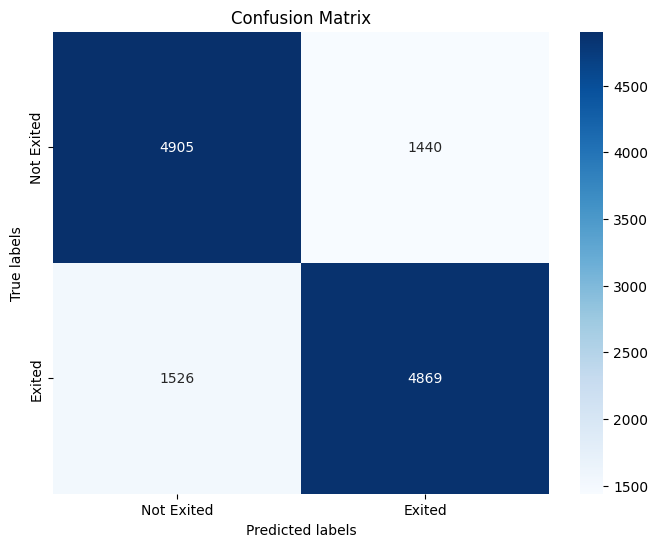

In [58]:
f1_calculated, precision, recall = calculate_f1_score(y_train, y_hat_train)
conf_matrix_calculated = calculate_confusion_matrix(y_train, y_hat_train)

f1_calculated, conf_matrix_calculated
print(f"The F1 score is: {(f1_calculated):0.4f}")
print(f"The precision score is: {(precision):0.4f}")
print(f"The recall score is: {(recall):0.4f}")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_calculated, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Not Exited', 'Exited'],
            yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

10

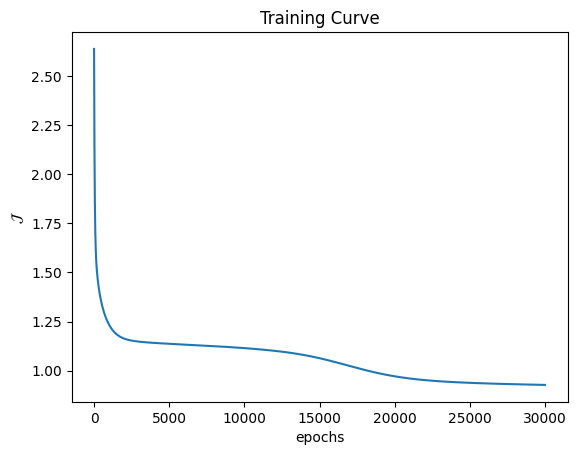

0.7520401757689893

In [50]:
sann = Shallow_ANN()
sann.fit(X_train, y_train,neurons = 12,eta=2e-2,epochs=3e4, show_curve=True)

y_pred_test = sann.predict(X_test)


acc = accuracy(y_test, y_pred_test)
acc

The F1 score is: 0.7494
The precision score is: 0.7456
The recall score is: 0.7532


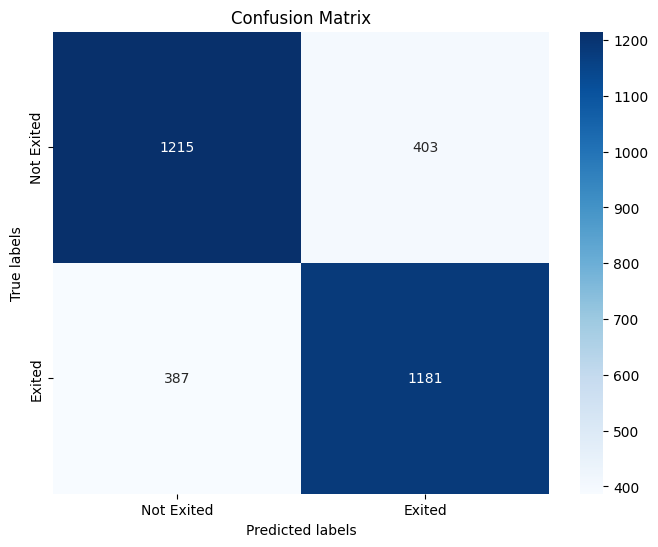

In [59]:
f1_calculated, precision, recall = calculate_f1_score(y_test, y_pred_test)
conf_matrix_calculated = calculate_confusion_matrix(y_test, y_pred_test)

f1_calculated, conf_matrix_calculated
print(f"The F1 score is: {(f1_calculated):0.4f}")
print(f"The precision score is: {(precision):0.4f}")
print(f"The recall score is: {(recall):0.4f}")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_calculated, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Not Exited', 'Exited'],
            yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
